## Дипко Олександра, КН-409

# Automatic Differentiation
:label:`sec_autograd`

As we have explained in :numref:`sec_calculus`,
differentiation is a crucial step in nearly all deep learning optimization algorithms.
While the calculations for taking these derivatives are straightforward,
requiring only some basic calculus,
for complex models, working out the updates by hand
can be a pain (and often error-prone).

In [2]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [3]:
x.requires_grad_(True)  # Same as `x = torch.arange(4.0, requires_grad=True)`
x.grad  # The default value is None

In [4]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

In [5]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [6]:
x.grad == 4 * x

tensor([True, True, True, True])

In [7]:
# PyTorch accumulates the gradient in default, we need to clear the previous
# values
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## Backward for Non-Scalar Variables

Technically, when `y` is not a scalar,
the most natural interpretation of the differentiation of a vector `y`
with respect to a vector `x` is a matrix.
For higher-order and higher-dimensional `y` and `x`,
the differentiation result could be a high-order tensor.

However, while these more exotic objects do show up
in advanced machine learning (including [**in deep learning**]),
more often (**when we are calling backward on a vector,**)
we are trying to calculate the derivatives of the loss functions
for each constituent of a *batch* of training examples.
Here, (**our intent is**) not to calculate the differentiation matrix
but rather (**the sum of the partial derivatives
computed individually for each example**) in the batch.


In [8]:
# Invoking `backward` on a non-scalar requires passing in a `gradient` argument
# which specifies the gradient of the differentiated function w.r.t `self`.
# In our case, we simply want to sum the partial derivatives, so passing
# in a gradient of ones is appropriate
x.grad.zero_()
y = x * x
# y.backward(torch.ones(len(x))) equivalent to the below
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

## Detaching Computation

Sometimes, we wish to [**move some calculations
outside of the recorded computational graph.**]
For example, say that `y` was calculated as a function of `x`,
and that subsequently `z` was calculated as a function of both `y` and `x`.
Now, imagine that we wanted to calculate
the gradient of `z` with respect to `x`,
but wanted for some reason to treat `y` as a constant,
and only take into account the role
that `x` played after `y` was calculated.

Here, we can detach `y` to return a new variable `u`
that has the same value as `y` but discards any information
about how `y` was computed in the computational graph.
In other words, the gradient will not flow backwards through `u` to `x`.
Thus, the following backpropagation function computes
the partial derivative of `z = u * x` with respect to `x` while treating `u` as a constant,
instead of the partial derivative of `z = x * x * x` with respect to `x`.


In [9]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [10]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Computing the Gradient of Python Control Flow

One benefit of using automatic differentiation
is that [**even if**] building the computational graph of (**a function
required passing through a maze of Python control flow**)
(e.g., conditionals, loops, and arbitrary function calls),
(**we can still calculate the gradient of the resulting variable.**)
In the following snippet, note that
the number of iterations of the `while` loop
and the evaluation of the `if` statement
both depend on the value of the input `a`.


In [11]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [12]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

In [13]:
a.grad == d / a

tensor(True)

# Calculus
:label:`sec_calculus`

Finding the area of a polygon had remained mysterious
until at least 2,500 years ago, when ancient Greeks divided a polygon into triangles and summed their areas.
To find the area of curved shapes, such as a circle,
ancient Greeks inscribed polygons in such shapes.
As shown in :numref:`fig_circle_area`,
an inscribed polygon with more sides of equal length better approximates
the circle. This process is also known as the *method of exhaustion*.

![Find the area of a circle with the method of exhaustion.](../img/polygon-circle.svg)
:label:`fig_circle_area`

In fact, the method of exhaustion is where *integral calculus* (will be described in :numref:`sec_integral_calculus`) originates from.
More than 2,000 years later,
the other branch of calculus, *differential calculus*,
was invented.
Among the most critical applications of differential calculus,
optimization problems consider how to do something *the best*.
As discussed in :numref:`subsec_norms_and_objectives`,
such problems are ubiquitous in deep learning.

In deep learning, we *train* models, updating them successively
so that they get better and better as they see more and more data.
Usually, getting better means minimizing a *loss function*,
a score that answers the question "how *bad* is our model?"
This question is more subtle than it appears.
Ultimately, what we really care about
is producing a model that performs well on data
that we have never seen before.
But we can only fit the model to data that we can actually see.
Thus we can decompose the task of fitting models into two key concerns:
(i) *optimization*: the process of fitting our models to observed data;
(ii) *generalization*: the mathematical principles and practitioners' wisdom
that guide as to how to produce models whose validity extends
beyond the exact set of data examples used to train them.

To help you understand
optimization problems and methods in later chapters,
here we give a very brief primer on differential calculus
that is commonly used in deep learning.

In [14]:
%matplotlib inline
import numpy as np
from IPython import display
from d2l import torch as d2l


def f(x):
    return 3 * x ** 2 - 4 * x

[**By setting $x=1$ and letting $h$ approach $0$,
the numerical result of $\frac{f(x+h) - f(x)}{h}$**]
in :eqref:`eq_derivative`
(**approaches $2$.**)
Though this experiment is not a mathematical proof,
we will see later that the derivative $u'$ is $2$ when $x=1$.


In [15]:
def numerical_lim(f, x, h):
    return (f(x + h) - f(x)) / h

h = 0.1
for i in range(5):
    print(f'h={h:.5f}, numerical limit={numerical_lim(f, 1, h):.5f}')
    h *= 0.1

h=0.10000, numerical limit=2.30000
h=0.01000, numerical limit=2.03000
h=0.00100, numerical limit=2.00300
h=0.00010, numerical limit=2.00030
h=0.00001, numerical limit=2.00003


In [16]:
def use_svg_display():  #@save
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')

In [17]:
def set_figsize(figsize=(3.5, 2.5)):  #@save
    """Set the figure size for matplotlib."""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize

In [18]:
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [19]:
#@save
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else d2l.plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

Now we can [**plot the function $u = f(x)$ and its tangent line $y = 2x - 3$ at $x=1$**], where the coefficient $2$ is the slope of the tangent line.


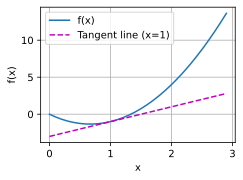

In [20]:
x = np.arange(0, 3, 0.1)
plot(x, [f(x), 2 * x - 3], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])

# Linear Algebra
:label:`sec_linear-algebra`


Now that you can store and manipulate data,
let us briefly review the subset of basic linear algebra
that you will need to understand and implement
most of models covered in this book.
Below, we introduce the basic mathematical objects, arithmetic,
and operations in linear algebra,
expressing each of them through mathematical notation
and the corresponding implementation in code.

## Scalars

If you never studied linear algebra or machine learning,
then your past experience with math probably consisted
of thinking about one number at a time.
And, if you ever balanced a checkbook
or even paid for dinner at a restaurant
then you already know how to do basic things
like adding and multiplying pairs of numbers.
For example, the temperature in Palo Alto is $52$ degrees Fahrenheit.
Formally, we call values consisting
of just one numerical quantity *scalars*.
If you wanted to convert this value to Celsius
(the metric system's more sensible temperature scale),
you would evaluate the expression $c = \frac{5}{9}(f - 32)$, setting $f$ to $52$.
In this equation, each of the terms---$5$, $9$, and $32$---are scalar values.
The placeholders $c$ and $f$ are called *variables*
and they represent unknown scalar values.

In this book, we adopt the mathematical notation
where scalar variables are denoted
by ordinary lower-cased letters (e.g., $x$, $y$, and $z$).
We denote the space of all (continuous) *real-valued* scalars by $\mathbb{R}$.
For expedience, we will punt on rigorous definitions
of what precisely *space* is,
but just remember for now that the expression $x \in \mathbb{R}$
is a formal way to say that $x$ is a real-valued scalar.
The symbol $\in$ can be pronounced "in"
and simply denotes membership in a set.
Analogously, we could write $x, y \in \{0, 1\}$
to state that $x$ and $y$ are numbers
whose value can only be $0$ or $1$.

(**A scalar is represented by a tensor with just one element.**)
In the next snippet, we instantiate two scalars
and perform some familiar arithmetic operations with them,
namely addition, multiplication, division, and exponentiation.


In [21]:
import torch

x = torch.tensor(3.0)
y = torch.tensor(2.0)

x + y, x * y, x / y, x**y

(tensor(5.), tensor(6.), tensor(1.5000), tensor(9.))

In [22]:
x = torch.arange(4)
x

tensor([0, 1, 2, 3])

In [23]:
x[3]

tensor(3)

In [24]:
len(x)

4

In [25]:
x.shape

torch.Size([4])

In [26]:
A = torch.arange(20).reshape(5, 4)
A

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19]])

In [27]:
A.T

tensor([[ 0,  4,  8, 12, 16],
        [ 1,  5,  9, 13, 17],
        [ 2,  6, 10, 14, 18],
        [ 3,  7, 11, 15, 19]])

In [28]:
B = torch.tensor([[1, 2, 3], [2, 0, 4], [3, 4, 5]])
B

tensor([[1, 2, 3],
        [2, 0, 4],
        [3, 4, 5]])

In [29]:
B == B.T

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

In [30]:
X = torch.arange(24).reshape(2, 3, 4)
X

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])

In [31]:
A = torch.arange(20, dtype=torch.float32).reshape(5, 4)
B = A.clone()  # Assign a copy of `A` to `B` by allocating new memory
A, A + B

(tensor([[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.],
         [16., 17., 18., 19.]]),
 tensor([[ 0.,  2.,  4.,  6.],
         [ 8., 10., 12., 14.],
         [16., 18., 20., 22.],
         [24., 26., 28., 30.],
         [32., 34., 36., 38.]]))

In [32]:
A * B

tensor([[  0.,   1.,   4.,   9.],
        [ 16.,  25.,  36.,  49.],
        [ 64.,  81., 100., 121.],
        [144., 169., 196., 225.],
        [256., 289., 324., 361.]])

In [33]:
a = 2
X = torch.arange(24).reshape(2, 3, 4)
a + X, (a * X).shape

(tensor([[[ 2,  3,  4,  5],
          [ 6,  7,  8,  9],
          [10, 11, 12, 13]],
 
         [[14, 15, 16, 17],
          [18, 19, 20, 21],
          [22, 23, 24, 25]]]),
 torch.Size([2, 3, 4]))

In [34]:
x = torch.arange(4, dtype=torch.float32)
x, x.sum()

(tensor([0., 1., 2., 3.]), tensor(6.))

In [35]:
A.shape, A.sum()

(torch.Size([5, 4]), tensor(190.))

In [36]:
A_sum_axis0 = A.sum(axis=0)
A_sum_axis0, A_sum_axis0.shape

(tensor([40., 45., 50., 55.]), torch.Size([4]))

In [37]:
A_sum_axis1 = A.sum(axis=1)
A_sum_axis1, A_sum_axis1.shape

(tensor([ 6., 22., 38., 54., 70.]), torch.Size([5]))

In [38]:
A.sum(axis=[0, 1])  # Same as `A.sum()`

tensor(190.)

In [39]:
A.mean(), A.sum() / A.numel()

(tensor(9.5000), tensor(9.5000))

In [40]:
A.mean(axis=0), A.sum(axis=0) / A.shape[0]

(tensor([ 8.,  9., 10., 11.]), tensor([ 8.,  9., 10., 11.]))

In [41]:
sum_A = A.sum(axis=1, keepdims=True)
sum_A

tensor([[ 6.],
        [22.],
        [38.],
        [54.],
        [70.]])

In [42]:
A / sum_A

tensor([[0.0000, 0.1667, 0.3333, 0.5000],
        [0.1818, 0.2273, 0.2727, 0.3182],
        [0.2105, 0.2368, 0.2632, 0.2895],
        [0.2222, 0.2407, 0.2593, 0.2778],
        [0.2286, 0.2429, 0.2571, 0.2714]])

In [43]:
A.cumsum(axis=0)

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.],
        [40., 45., 50., 55.]])

In [44]:
y = torch.ones(4, dtype=torch.float32)
x, y, torch.dot(x, y)

(tensor([0., 1., 2., 3.]), tensor([1., 1., 1., 1.]), tensor(6.))

In [45]:
torch.sum(x * y)

tensor(6.)

In [46]:
A.shape, x.shape, torch.mv(A, x)

(torch.Size([5, 4]), torch.Size([4]), tensor([ 14.,  38.,  62.,  86., 110.]))

In [47]:
B = torch.ones(4, 3)
torch.mm(A, B)

tensor([[ 6.,  6.,  6.],
        [22., 22., 22.],
        [38., 38., 38.],
        [54., 54., 54.],
        [70., 70., 70.]])

In [48]:
u = torch.tensor([3.0, -4.0])
torch.norm(u)

tensor(5.)

In [49]:
torch.abs(u).sum()

tensor(7.)

In [50]:
torch.norm(torch.ones((4, 9)))

tensor(6.)

## Finding All the Functions and Classes in a Module

In order to know which functions and classes can be called in a module, we
invoke the `dir` function. For instance, we can (**query all properties in the
module for generating random numbers**):


In [51]:
import torch

print(dir(torch.distributions))

['AbsTransform', 'AffineTransform', 'Bernoulli', 'Beta', 'Binomial', 'CatTransform', 'Categorical', 'Cauchy', 'Chi2', 'ComposeTransform', 'ContinuousBernoulli', 'CorrCholeskyTransform', 'Dirichlet', 'Distribution', 'ExpTransform', 'Exponential', 'ExponentialFamily', 'FisherSnedecor', 'Gamma', 'Geometric', 'Gumbel', 'HalfCauchy', 'HalfNormal', 'Independent', 'IndependentTransform', 'Kumaraswamy', 'LKJCholesky', 'Laplace', 'LogNormal', 'LogisticNormal', 'LowRankMultivariateNormal', 'LowerCholeskyTransform', 'MixtureSameFamily', 'Multinomial', 'MultivariateNormal', 'NegativeBinomial', 'Normal', 'OneHotCategorical', 'OneHotCategoricalStraightThrough', 'Pareto', 'Poisson', 'PowerTransform', 'RelaxedBernoulli', 'RelaxedOneHotCategorical', 'ReshapeTransform', 'SigmoidTransform', 'SoftmaxTransform', 'StackTransform', 'StickBreakingTransform', 'StudentT', 'TanhTransform', 'Transform', 'TransformedDistribution', 'Uniform', 'VonMises', 'Weibull', '__all__', '__builtins__', '__cached__', '__doc__'

In [52]:
torch.ones(4)

tensor([1., 1., 1., 1.])

# Data Manipulation
:label:`sec_ndarray`

In order to get anything done, we need some way to store and manipulate data.
Generally, there are two important things we need to do with data: (i) acquire
them; and (ii) process them once they are inside the computer.  There is no
point in acquiring data without some way to store it, so let us get our hands
dirty first by playing with synthetic data.  To start, we introduce the
$n$-dimensional array, which is also called the *tensor*.

If you have worked with NumPy, the most widely-used
scientific computing package in Python,
then you will find this section familiar.
No matter which framework you use,
its *tensor class* (`ndarray` in MXNet,
`Tensor` in both PyTorch and TensorFlow) is similar to NumPy's `ndarray` with
a few killer features.
First, GPU is well-supported to accelerate the computation
whereas NumPy only supports CPU computation.
Second, the tensor class
supports automatic differentiation.
These properties make the tensor class suitable for deep learning.
Throughout the book, when we say tensors,
we are referring to instances of the tensor class unless otherwise stated.

## Getting Started

In this section, we aim to get you up and running,
equipping you with the basic math and numerical computing tools
that you will build on as you progress through the book.
Do not worry if you struggle to grok some of
the mathematical concepts or library functions.
The following sections will revisit this material
in the context of practical examples and it will sink in.
On the other hand, if you already have some background
and want to go deeper into the mathematical content, just skip this section.


In [53]:
import torch

In [54]:
x = torch.arange(12)
x

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [55]:
x.shape

torch.Size([12])

In [56]:
x.numel()

12

In [57]:
X = x.reshape(3, 4)
X

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [58]:
torch.zeros((2, 3, 4))

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [59]:
torch.ones((2, 3, 4))

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

In [60]:
torch.randn(3, 4)

tensor([[-0.5072, -1.5148, -0.2493,  1.0498],
        [-0.2103,  0.1846, -0.3283, -1.2779],
        [-0.8542, -1.3083, -1.9118,  0.4957]])

In [61]:
torch.tensor([[2, 1, 4, 3], [1, 2, 3, 4], [4, 3, 2, 1]])

tensor([[2, 1, 4, 3],
        [1, 2, 3, 4],
        [4, 3, 2, 1]])

In [62]:
x = torch.tensor([1.0, 2, 4, 8])
y = torch.tensor([2, 2, 2, 2])
x + y, x - y, x * y, x / y, x**y  # The ** operator is exponentiation

(tensor([ 3.,  4.,  6., 10.]),
 tensor([-1.,  0.,  2.,  6.]),
 tensor([ 2.,  4.,  8., 16.]),
 tensor([0.5000, 1.0000, 2.0000, 4.0000]),
 tensor([ 1.,  4., 16., 64.]))

Many (**more operations can be applied elementwise**),
including unary operators like exponentiation.


In [63]:
torch.exp(x)

tensor([2.7183e+00, 7.3891e+00, 5.4598e+01, 2.9810e+03])

In [64]:
X = torch.arange(12, dtype=torch.float32).reshape((3, 4))
Y = torch.tensor([[2.0, 1, 4, 3], [1, 2, 3, 4], [4, 3, 2, 1]])
torch.cat((X, Y), dim=0), torch.cat((X, Y), dim=1)

(tensor([[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [ 2.,  1.,  4.,  3.],
         [ 1.,  2.,  3.,  4.],
         [ 4.,  3.,  2.,  1.]]),
 tensor([[ 0.,  1.,  2.,  3.,  2.,  1.,  4.,  3.],
         [ 4.,  5.,  6.,  7.,  1.,  2.,  3.,  4.],
         [ 8.,  9., 10., 11.,  4.,  3.,  2.,  1.]]))

In [65]:
X == Y

tensor([[False,  True, False,  True],
        [False, False, False, False],
        [False, False, False, False]])

In [66]:
X.sum()

tensor(66.)

In [67]:
a = torch.arange(3).reshape((3, 1))
b = torch.arange(2).reshape((1, 2))
a, b

(tensor([[0],
         [1],
         [2]]),
 tensor([[0, 1]]))

In [68]:
a + b

tensor([[0, 1],
        [1, 2],
        [2, 3]])

In [69]:
X[-1], X[1:3]

(tensor([ 8.,  9., 10., 11.]),
 tensor([[ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]]))

In [70]:
X[1, 2] = 9
X

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  9.,  7.],
        [ 8.,  9., 10., 11.]])

In [71]:
X[0:2, :] = 12
X

tensor([[12., 12., 12., 12.],
        [12., 12., 12., 12.],
        [ 8.,  9., 10., 11.]])

In [72]:
before = id(Y)
Y = Y + X
id(Y) == before

False

In [73]:
Z = torch.zeros_like(Y)
print('id(Z):', id(Z))
Z[:] = X + Y
print('id(Z):', id(Z))

id(Z): 2697364841472
id(Z): 2697364841472


In [74]:
before = id(X)
X += Y
id(X) == before

True

In [75]:
A = X.numpy()
B = torch.from_numpy(A)
type(A), type(B)

(numpy.ndarray, torch.Tensor)

In [76]:
a = torch.tensor([3.5])
a, a.item(), float(a), int(a)

(tensor([3.5000]), 3.5, 3.5, 3)

# Data Preprocessing
:label:`sec_pandas`

So far we have introduced a variety of techniques for manipulating data that are already stored in tensors.
To apply deep learning to solving real-world problems,
we often begin with preprocessing raw data, rather than those nicely prepared data in the tensor format.
Among popular data analytic tools in Python, the `pandas` package is commonly used.
Like many other extension packages in the vast ecosystem of Python,
`pandas` can work together with tensors.
So, we will briefly walk through steps for preprocessing raw data with `pandas`
and converting them into the tensor format.
We will cover more data preprocessing techniques in later chapters.

## Reading the Dataset

As an example,
we begin by (**creating an artificial dataset that is stored in a
csv (comma-separated values) file**)
`../data/house_tiny.csv`. Data stored in other
formats may be processed in similar ways.

Below we write the dataset row by row into a csv file.


In [77]:
import os

os.makedirs(os.path.join('..', 'data'), exist_ok=True)
data_file = os.path.join('..', 'data', 'house_tiny.csv')
with open(data_file, 'w') as f:
    f.write('NumRooms,Alley,Price\n')  # Column names
    f.write('NA,Pave,127500\n')  # Each row represents a data example
    f.write('2,NA,106000\n')
    f.write('4,NA,178100\n')
    f.write('NA,NA,140000\n')

In [78]:
# If pandas is not installed, just uncomment the following line:
# !pip install pandas
import pandas as pd

data = pd.read_csv(data_file)
print(data)

   NumRooms Alley   Price
0       NaN  Pave  127500
1       2.0   NaN  106000
2       4.0   NaN  178100
3       NaN   NaN  140000


In [79]:
inputs, outputs = data.iloc[:, 0:2], data.iloc[:, 2]
inputs = inputs.fillna(inputs.mean())
print(inputs)

   NumRooms Alley
0       3.0  Pave
1       2.0   NaN
2       4.0   NaN
3       3.0   NaN


<ipython-input-79-7f3bcd4dc11f>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  inputs = inputs.fillna(inputs.mean())


In [80]:
inputs = pd.get_dummies(inputs, dummy_na=True)
print(inputs)

   NumRooms  Alley_Pave  Alley_nan
0       3.0           1          0
1       2.0           0          1
2       4.0           0          1
3       3.0           0          1


In [81]:
import torch

X, y = torch.tensor(inputs.values), torch.tensor(outputs.values)
X, y

(tensor([[3., 1., 0.],
         [2., 0., 1.],
         [4., 0., 1.],
         [3., 0., 1.]], dtype=torch.float64),
 tensor([127500, 106000, 178100, 140000]))

# Probability
:label:`sec_prob`

In some form or another, machine learning is all about making predictions.
We might want to predict the *probability* of a patient suffering a heart attack in the next year, given their clinical history. In anomaly detection, we might want to assess how *likely* a set of readings from an airplane's jet engine would be, were it operating normally. In reinforcement learning, we want an agent to act intelligently in an environment. This means we need to think about the probability of getting a high reward under each of the available actions. And when we build recommender systems we also need to think about probability. For example, say *hypothetically* that we worked for a large online bookseller. We might want to estimate the probability that a particular user would buy a particular book. For this we need to use the language of probability.
Entire courses, majors, theses, careers, and even departments, are devoted to probability. So naturally, our goal in this section is not to teach the whole subject. Instead we hope to get you off the ground, to teach you just enough that you can start building your first deep learning models, and to give you enough of a flavor for the subject that you can begin to explore it on your own if you wish.


In [82]:
%matplotlib inline
import torch
from torch.distributions import multinomial
from d2l import torch as d2l


In [83]:
fair_probs = torch.ones([6]) / 6
multinomial.Multinomial(1, fair_probs).sample()

tensor([0., 0., 0., 0., 0., 1.])

In [84]:
multinomial.Multinomial(10, fair_probs).sample()

tensor([2., 3., 1., 1., 1., 2.])

In [85]:
# Store the results as 32-bit floats for division
counts = multinomial.Multinomial(1000, fair_probs).sample()
counts / 1000  # Relative frequency as the estimate

tensor([0.1770, 0.1630, 0.1640, 0.1540, 0.1550, 0.1870])

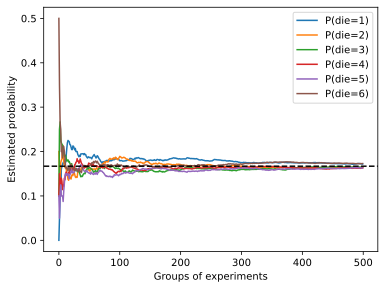

In [86]:
counts = multinomial.Multinomial(10, fair_probs).sample((500,))
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)

d2l.set_figsize((6, 4.5))
for i in range(6):
    d2l.plt.plot(estimates[:, i].numpy(), label=("P(die=" + str(i + 1) + ")"))
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Groups of experiments')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend();